In [1]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (TwoSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

/home/soyeon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
experiment_dir = '/data/EFAT/EFAT_output'
output_dir = 'datasink'
working_dir = 'workingdir'

fwhm = [8]

subject_list_HC = ['005', '006', '007', 
                   '010', '013', '014', '015', 
                   '019', '021', '022', '025', 
                   '026', '029', '032', '034', 
                   '036', '039', '041', 
                   '045', '050', 
                   '055', '056', '058', '059']

subject_list_PT = [
                  
                 
               
                    '058', '060', '066',  
                    '074', '075', '080', 
                    '082', '083', '084', '086', '087', '089', 
                    '095', '096', '101', '103', 
                    '104', '105', '106', '108', 
                    '113', '114', '117', '118', '120', '121', 
                    '124', '125', '128', '131', 
                    '134', '136', '138', '140', '141', 
                    '142', '143', '146', '150', 
                    '153', '156', '159', '160', '162', '165', 
                    '168', '169', '171', '181', '182', 
                    '183', '190', '193', '199', 
                    '201', '205', '206', '209', '212']


#contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 
#                 'con_0006', 'con_0007', 'con_0008', 'con_0009', 'con_0010']

mask = "/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [4]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# TwoSampleTTestDesign - creates two sample T-Test Design
twosamplettestdes = Node(TwoSampleTTestDesign(),
                         name="twosampttestdes")
twosamplettestdes.inputs.group1_files = ['/data/EFAT/EFAT_output/HC/datasink/1stLevel/sub-%s/fwhm-8/con_0007.nii' % (HC)
                                         for HC in subject_list_HC]
twosamplettestdes.inputs.group2_files = ['/data/EFAT/EFAT_output/PT/datasink/1stLevel/sub-%s/fwhm-8/con_0007.nii' % (PT)
                                         for PT in subject_list_PT]

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['HC', 'T', ['Group_{1}'], [1]]
cont2 = ['PT', 'T', ['Group_{2}'], [1]]
cont3 = ['HC > PT', 'T', ['Group_{1}','Group_{2}'], [1, -1]]
cont4 = ['PT > HC', 'T', ['Group_{1}','Group_{2}'], [-1, 1]]
level2conestimate.inputs.contrasts = [cont1, cont2, cont3, cont4]

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [5]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(gunzip, twosamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (twosamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2estimate, datasink, [('mask_image',
                                                 '2ndLevel.@mask')]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    ])

190125-16:26:58,919 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output/workingdir/l2analysis/graph.png (graph2use=colored, simple_form=True).


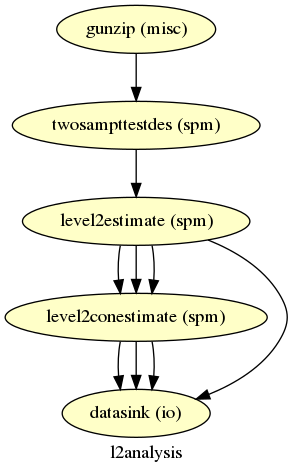

In [6]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'l2analysis', 'graph.png'))

In [7]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

190125-16:27:01,998 nipype.workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
190125-16:27:02,16 nipype.workflow INFO:
	 Running in parallel.
190125-16:27:02,20 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
190125-16:27:02,138 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.gunzip" in "/data/EFAT/EFAT_output/workingdir/l2analysis/gunzip".
190125-16:27:02,149 nipype.workflow INFO:
	 [Node] Running "gunzip" ("nipype.algorithms.misc.Gunzip")
190125-16:27:02,268 nipype.workflow INFO:
	 [Node] Finished "l2analysis.gunzip".
190125-16:27:04,23 nipype.workflow INFO:
	 [Job 0] Completed (l2analysis.gunzip).
190125-16:27:04,30 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
190125-16:27:04,175 nipype.workflow INFO:
	 [Node] Setting-up "l2analysis.twosampttestdes" in "/data/EFAT/EFAT_output/w

In [8]:
from nilearn.plotting import (plot_stat_map, plot_img)
%matplotlib inline
anatimg = '/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/home/soyeon/.local/lib/python3.6/site-packages/nilearn/plotting/displays.py:684: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


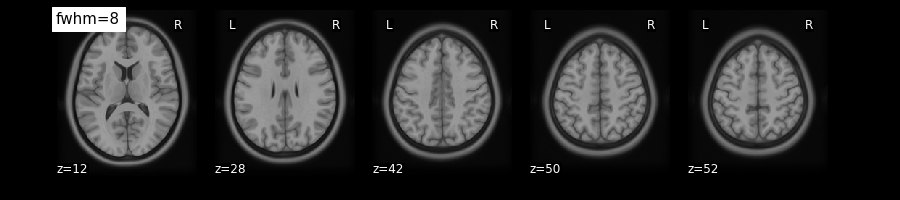

In [9]:
plot_stat_map(
    '/data/EFAT/EFAT_output/datasink/2ndLevel/con_0004.nii', title='fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='z', cut_coords=(12, 42, 50, 52, 28), cmap='viridis', draw_cross=True);

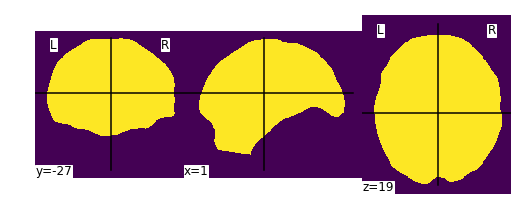

In [15]:
plot_img('/data/EFAT/EFAT_output/datasink/2ndLevel/mask.nii')